## 0.Setting

In [0]:
######### F12 -> console ###########
"""
function ClickConnect() { // 백엔드를 할당하지 못했습니다. 
  // GPU이(가) 있는 백엔드를 사용할 수 없습니다. 가속기가 없는 런타임을 사용하시겠습니까? 
  // 취소 버튼을 찾아서 클릭 
  var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
  buttons.forEach(function(btn) { btn.click(); }); 
  console.log("1분마다 자동 재연결"); 
  document.querySelector("#top-toolbar > colab-connect-button").click(); 
} 
setInterval(ClickConnect,1000*60);
"""

'\nfunction ClickConnect() { // 백엔드를 할당하지 못했습니다. \n  // GPU이(가) 있는 백엔드를 사용할 수 없습니다. 가속기가 없는 런타임을 사용하시겠습니까? \n  // 취소 버튼을 찾아서 클릭 \n  var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); \n  buttons.forEach(function(btn) { btn.click(); }); \n  console.log("1분마다 자동 재연결"); \n  document.querySelector("#top-toolbar > colab-connect-button").click(); \n} \nsetInterval(ClickConnect,1000*60);\n'

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 각자 경로 지정해주세요
cd /content/drive/My\ Drive/tobigs/snorrr2

/content/drive/My Drive/tobigs/snorrr2


In [0]:
ls

 aug_data.zip                   new_snorrr_true_false_light.ipynb
 converted_model.tflite         new_snorrr_true_false_light_keras.ipynb
 data/                          noise/
 data_aug/                      preprocessing_normalization_test.ipynb
 data_small/                    raw_data.zip
'Mobilenet_colab(aug ver)'      temp.mp3
 Mobilenet_colab_eunsun.ipynb   test.csv
 Mobilenet_colab.ipynb          Untitled0.ipynb
 model/                         very_quite_with_app.mp3
 new_snorrr.ipynb               weight/
 new_snorrr_true_false.ipynb


In [0]:
# !unzip data_aug/Home/home.zip -d data_aug/Home

In [0]:
!pip install pydub

#### audio.csv 만들기

In [0]:
cd ./data_aug

/content/drive/My Drive/tobigs/snorrr2/data_aug


In [0]:
import pandas as pd
import os

label_info = ['Male speech, man speaking','Outside, rural or natural','snoring','Traffic noise, roadway noise','Vehicle','Home']
df = pd.DataFrame({"file_name":[], "labels":[]})
for label in os.listdir():
  if label=='__MACOSX':
      continue
  label_dir = os.path.join(os.getcwd(), label)
  current_label_num = label_info.index(label)+1
  for file in os.listdir(label_dir):
    if file.endswith("mp3"):
      df = df.append({"file_name":file, "labels":int(current_label_num)} , ignore_index=True)
df.labels = df['labels'].astype(int)
df = df[df['file_name'].isin(df[df.file_name.duplicated()]['file_name'])==False]

In [0]:
df.to_csv('./audio.csv',index=False)

In [0]:
df.shape

(11718, 2)

## 1.Loader

In [0]:
cd /content/drive/My\ Drive/tobigs/snorrr2

/content/drive/My Drive/tobigs/snorrr2


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa
import pydub 
from fastprogress import master_bar, progress_bar
import numpy as np
import time
import os
import warnings
from sklearn.metrics import classification_report
import random
from functools import partial

In [0]:
pwd

'/content/drive/My Drive/tobigs/snorrr2'

In [0]:
# Split
warnings.filterwarnings(action="ignore")
data_folder = 'data_aug'
path1 = f"./{data_folder}/Male speech, man speaking" 
path2 = f"./{data_folder}/Outside, rural or natural" 
path3 = f"./{data_folder}/snoring" 
path4 = f"./{data_folder}/Traffic noise, roadway noise" 
path5 = f"./{data_folder}/Vehicle" 
path6 = f"./{data_folder}/Home" 

df = pd.read_csv(f"./{data_folder}/audio.csv")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=7) 
train_df, valid_df = train_test_split(train_df, test_size=0.3, random_state=7) 

train_df = train_df.reset_index()
valid_df = valid_df.reset_index()
test_df = test_df.reset_index()

print(len(train_df),len(valid_df),len(test_df))

6561 2813 2344


## 2.Augmentation

In [0]:
# from pydub import AudioSegment

# #1. 피치 조정
# def freq_augmentation(y, sr):
#     switch = np.random.randint(1,3)
#     if(switch==1): #고음
#         rate = np.random.uniform(2, 5)
#     elif(switch==2): #저음
#         rate = np.random.uniform(-5, -2)
#     y = librosa.effects.pitch_shift(y, sr, n_steps=rate)
#     return y

# #2. 노이즈 삽입
# def adding_random_noise(y, noise_rate=0.005):
#     rn = np.random.randn(len(y))
#     data_rn = y + noise_rate*rn
#     return data_rn

# #3. 마이너스 삽입
# def minus_sound(y):
#     temp_numpy = (-1)*y
#     return temp_numpy

# #4. Rolling
# def shifting_sound(data,  roll_rate=0.3):
#     # 그냥 [1, 2, 3, 4] 를 [4, 1, 2, 3]으로 만들어주는건데 이게 효과있는지는 잘 모르겠
#     data_roll = np.roll(data, int(len(data) * roll_rate))
#     return data_roll

# # 5. Strech
# def stretch_sound(data, rate=0.7):
#     # stretch 해주는거 비율이 뭐가 좋은지 잘모르겟, 0.8이랑, 1.2랑 차이가 안나는거 같음
#     stretch_data = librosa.effects.time_stretch(data, rate)
#     return stretch_data

# # 6. Reverse
# def reverse_sound(data):
#     temp_array = []
#     for i in range(len(data)):
#         temp_array.append(data[len(data)-1-i])
#     temp_numpy =np.asarray(temp_array)
#     return temp_numpy


## 3.Feature Extracting

In [0]:
# mfcc
def get_mfcc(file_path, isTrain, sr=44100, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80, norm='norm'):

  # 1.wav 로드
  wav,sr = librosa.load(file_path,sr=sr)
  print(np.min(wav), np.max(wav))
  if norm=='norm':
    wav = 2*((wav - np.min(wav)) / (np.max(wav) - np.min(wav)))-1
    # wav = librosa.util.normalize(wav)
    

  # 2.패딩 작업
  if wav.shape[0]<(10*sr) : 
    wav=np.pad(wav,int(np.ceil((10*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:10*sr]
    
  # 3. 추출
  try:
    mfcc = librosa.feature.mfcc(wav, sr, n_mfcc=50) 
    # if len(mfcc[1])!=862:
    #   print(wav.shape, mfcc.shape, file_path)
  except Exception as ex: # 에러 종류
    print('에러가 발생 했습니다', ex) # ex는 발생한 에러의 이름을 받아오는 변
    print(file_path)
  return mfcc

def spec_to_image(spec, eps=1e-6):
    # 이미지 자체를 정규화 해서 비슷한 밝기의 spectrogram이 나오도록 함.
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    # spec_min, spec_max = spec_norm.min(), spec_norm.max()
    # spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
    # spec_scaled = spec_scaled.astype(np.uint8)
    return spec_norm

## 4.Loader

In [0]:
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, df, batch_size, shuffle = True, train=False):
        self.X = list(df['file_name'])
        self.y = list(df['labels'])
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.train=train
    
    # 셔플
    def on_epoch_end(self): 
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # 길이
    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))
    
    # 제네레이터
    def __data_generation(self, X_list, y_list):
        X = []
        y = []
        
        for i, (img_dir, label) in enumerate(zip(X_list, y_list)):
          if label == 1:
              audio_path = os.path.join(path1, img_dir)
          elif label ==2:
              audio_path = os.path.join(path2, img_dir)
          elif label == 3:
              audio_path = os.path.join(path3, img_dir)
          elif label == 4:
              audio_path = os.path.join(path4, img_dir)
          elif label == 5:
              audio_path = os.path.join(path5, img_dir)
          elif label == 6:
              audio_path = os.path.join(path6, img_dir)

          # mfcc후 전처리
          image = get_mfcc(audio_path, self.train)
          # image = spec_to_image(image)
          image = np.expand_dims(image, axis=2)
          image = np.repeat(image,3,axis=2)
 
          # label True False로 바꾸기
          if label ==3:
            label = 1
          else:
            label = 0
          
          # 추가
          X.append(image)
          one_hot_label= [0,0]
          one_hot_label[label] = 1
          y.append(np.array(one_hot_label))
        
        # batch size 만큼 있던거 stack하기
        X = np.stack(X, axis=0)
        y = np.stack(y, axis=0)


        return X, y
        
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        X_list = [self.X[k] for k in indexes]
        y_list = [self.y[k] for k in indexes]
        X, y = self.__data_generation(X_list, y_list)
        # print('get')
        return X, y

Using TensorFlow backend.


In [0]:
# generator 할당
train_generator = DataGenerator(train_df, 64, train=True)
valid_generator = DataGenerator(valid_df, 64)
test_generator = DataGenerator(test_df, 12, shuffle=False)

# 5.Modeling

In [0]:
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import *

In [0]:
# MobilenetV2 + 풀링후 softmax 
# Fine Tuning 돌려보도록
num_classes = 2
model = Sequential()
model.add(MobileNetV2(input_shape=(50, 862, 3),weights='imagenet',include_top=False))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes,activation='softmax'))












9412608/9406464 [==============================] - 2s 0us/step


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 2, 27, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
# Auc Metric 추가 코드
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [0]:
# Save Callbacks
MODEL_SAVE_PATH = './weight/'
if not os.path.exists(MODEL_SAVE_PATH):
  os.mkdir(MODEL_SAVE_PATH)
model_path = MODEL_SAVE_PATH + '{epoch:02d}-{acc:.4f}_weight.hdf5'

cb_checkpoint = ModelCheckpoint(model_path,monitor='val_auc', verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto', period=1)

In [0]:
# Compile
lr = 3e-3 
opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy", auc])



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


#### 5-1.Train

In [0]:
# u37262.mp3가 이상했었우!
model.fit_generator(
    generator = train_generator,
    validation_data = valid_generator,
    epochs=20,
    workers = -1,
    use_multiprocessing=True,
    callbacks = [cb_checkpoint])

Epoch 1/20
102/102 [==============================] - 10394s 102s/step - loss: 0.3188 - acc: 0.8794 - auc: 0.8906 - val_loss: 2.4787 - val_acc: 0.6381 - val_auc: 0.8780
Epoch 2/20
102/102 [==============================] - 4559s 45s/step - loss: 0.1537 - acc: 0.9413 - auc: 0.8699 - val_loss: 0.8338 - val_acc: 0.8052 - val_auc: 0.8935
Epoch 3/20
102/102 [==============================] - 4570s 45s/step - loss: 0.0989 - acc: 0.9646 - auc: 0.9070 - val_loss: 0.6091 - val_acc: 0.8354 - val_auc: 0.9194
Epoch 4/20
102/102 [==============================] - 4807s 47s/step - loss: 0.0712 - acc: 0.9758 - auc: 0.9278 - val_loss: 0.1939 - val_acc: 0.9466 - val_auc: 0.9379
Epoch 5/20
102/102 [==============================] - 4558s 45s/step - loss: 0.0489 - acc: 0.9851 - auc: 0.9456 - val_loss: 0.1813 - val_acc: 0.9473 - val_auc: 0.9518
Epoch 6/20
102/102 [==============================] - 4668s 46s/step - loss: 0.0304 - acc: 0.9910 - auc: 0.9567 - val_loss: 0.2019 - val_acc: 0.9517 - val_auc: 0.9

####  5-2 Evaluate

In [0]:
model.load_weights("/content/drive/My Drive/snore_eunsun/weight_mobilenet/09-0.9979_weight.hdf5")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy', auc])
model.evaluate(x=test_generator)

NameError: ignored

## model file로 판단

In [0]:
# model.load_weights("./model/09-0.9979_weight.hdf5")
model.load_weights("./weight/mfcc_true_false_50_aug_with_quite_sound/weight13-0.9989_weight.hdf5")

In [0]:

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy', auc])

# image = get_mfcc('./data/test.wav', False)
# image = get_mfcc('./data_aug/snoring/84_0.mp3', False)
# image = get_mfcc('./data/very_quite2.mp3', False)
image = get_mfcc('./data/very_quite2_with_app.mp3', False)

# image = get_mfcc('./data/very_quite.wav', False)
# image = get_mfcc('./data/3223.mp3', False) 
# image = get_mfcc('./data/3223_record.mp3', False) 
# image = get_mfcc('./data/3223_with_record_app.mp3', False) 
# image = get_mfcc('./data/3223_record_voice_recog_ver.wav', False) 


### 정규화하기
# image = spec_to_image(image) # 헐 이거 하긴 해야되네... 흙
### RGB로 바꾸기
image = np.expand_dims(image, axis=2)
image = np.repeat(image,3,axis=2)
image = np.expand_dims(image, axis=0) # 1 50 431 3


ValueError: ignored

In [0]:
predict = model.predict(image) # snoring/84_0.mp3
predict

array([[0.0029352 , 0.99706477]], dtype=float32)

In [0]:
predict = model.predict(image) # very_quite2.mp3
predict

array([[9.9925417e-01, 7.4579794e-04]], dtype=float32)

In [0]:
predict = model.predict(image) # very_quite_with_app.mp3
predict

array([[9.9998534e-01, 1.4614273e-05]], dtype=float32)

In [0]:
# 원래는 array([[0.01051776, 0.9894823 ]]
predict = model.predict(image) # very_quite.wav # norm 
predict

array([[0.38864776, 0.6113522 ]], dtype=float32)

In [0]:
# 원래는 array([[0.98467124, 0.01532878]], dtype=float32)
predict = model.predict(image) # 3223.mp3
predict

array([[9.9997807e-01, 2.1937753e-05]], dtype=float32)

In [0]:
# 원래는 array([[0.00899873, 0.9910013 ]]
predict = model.predict(image) # 3223_record.mp3
predict

array([[0.04705795, 0.9529421 ]], dtype=float32)

In [0]:
# 원래 array([[0.9974118 , 0.00258821]]
predict = model.predict(image) # 3223_with_record_app.mp3
predict

array([[0.9062323 , 0.09376767]], dtype=float32)

In [0]:
predict = model.predict(image) # 3223_record_voice_recog_ver.wav
predict

array([[9.9998069e-01, 1.9253865e-05]], dtype=float32)

# TFLITE





## Export

In [0]:
# weight말고 모델 자체 save
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
model.load_weights("./weight/mfcc_true_false_50_aug_with_quite_sound/weight13-0.9989_weight.hdf5")
model.save('./model/whole_model.hdf5')

ValueError: ignored

In [0]:
import tensorflow as tf

# Convert the model.
# tf.contrib.lite.TFLiteConverter.from_keras_model_file
converter = tf.lite.TFLiteConverter.from_keras_model_file('./model/whole_model.hdf5')
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 262 variables.
INFO:tensorflow:Converted 262 variables to const ops.


8862772

## TfliTE evaluate

In [0]:
import tensorflow as tf
# model_content, model_path
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

In [0]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [0]:
print(input_details[0]['shape'])
print(output_details[0]['shape'])

[  1  50 862   3]
[1 2]
ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [0]:
# image = get_mfcc('./data/very_quite.wav', False)
# image = get_mfcc('./data/3223.mp3', False) 
# image = get_mfcc('./data/3223_record.mp3', False) 
# image = get_mfcc('./data/3223_with_record_app.mp3', False) 
# image = get_mfcc('./data/3223_record_voice_recog_ver.wav', False) 

In [0]:
image = get_mfcc('./data/very_quite6.mp3', False)
# image = get_mfcc('./data/3223_with_record_app.mp3', False)
# image = get_mfcc('./data/3223_record.mp3', False)

print(image)
print(image.shape)
### RGB로 바꾸기
image = np.expand_dims(image, axis=2)
image = np.repeat(image,3,axis=2)
image = np.expand_dims(image, axis=0) # expand_dim
image = image.astype(np.float32)

[[ -33.45237247  -98.825626   -423.69095189 ... -597.53346996
  -602.28915108 -602.96261139]
 [  68.45516821   68.19107979   17.67531277 ...   34.56706944
    30.62041843   30.45106273]
 [ -11.26701615  -10.89120474  -18.14158214 ...   26.50169799
    27.10256336   28.22980944]
 ...
 [  -3.3340054    -2.39372968   18.5853179  ...    7.10404144
     4.97821022    6.41466703]
 [   9.08352957    9.30338181    4.53944634 ...    8.23538058
     6.18190115    6.57565666]
 [  -4.26628614   -3.74000386    1.57289079 ...    8.64111731
     6.61657474    6.35284549]]
(50, 862)


In [0]:
import numpy as np
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(tflite_results)
# tf_results = model.predict(image)

[[0.9986008 0.0013992]]


In [0]:
import numpy as np
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(tflite_results)
# tf_results = model.predict(image)

[[0.90623367 0.09376636]]


In [0]:
import numpy as np
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(tflite_results)
# tf_results = model.predict(image)

[[0.04705618 0.9529438 ]]


## Androidd csv quality check


[[-430.74884   -430.7488    -426.54865   ... -416.80008   -415.9061
  -410.29733  ]
 [   9.891162     9.891173    15.802215  ...   28.160126    30.61018
    37.80542  ]
 [   9.888927     9.888939    15.713824  ...   27.997475    29.829357
    35.021336 ]
 ...
 [   8.29164      8.29165      6.519956  ...    4.973211     5.1488543
     5.2656617]
 [   8.224819     8.22483      6.357386  ...    4.1080403    5.399488
     5.568118 ]
 [   8.15676      8.15677      6.1997933 ...    3.6935272    5.439737
     5.791343 ]]


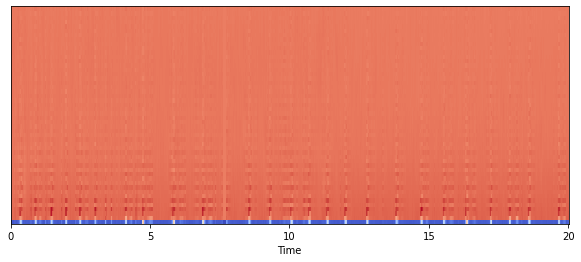

In [0]:
csv_data = np.loadtxt('./data/test0406.csv', delimiter=",", dtype=np.float32)

### 정규화하기
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10, 4))
image = np.transpose(csv_data.reshape((862,50)))
print(image)
# iamge = spec_to_image(image)
librosa.display.specshow(image, x_axis='time')

plt.show()



-0.9911194 0.8352051
[[-683.11332428 -679.96274107 -659.48686956 ... -638.89639111
  -637.52919968 -628.81087968]
 [   9.66145677   14.09550078   31.01313346 ...   43.16968017
    51.82334863   66.7642067 ]
 [   9.65927424   14.02901965   29.27976693 ...   42.37472572
    45.61594389   48.19024227]
 ...
 [   8.0990816     7.34494983    5.61747915 ...    6.70544532
     4.53648027    3.01971068]
 [   8.03381265    7.28080443    3.71700607 ...    3.84447043
     4.28881977    2.26139136]
 [   7.96733383    7.21069267    3.60919956 ...    5.35925253
     5.03156686    2.06142378]]


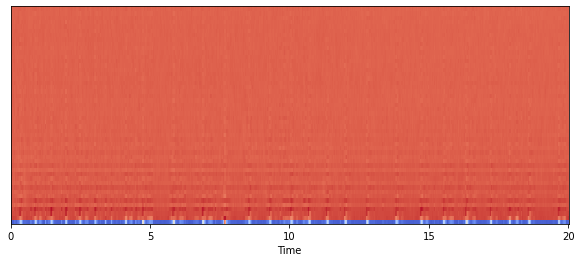

In [0]:
import matplotlib.pyplot as plt
import librosa
plt.figure(figsize=(10, 4))
image = get_mfcc('./data/test0406.wav',isTrain=False) # 일단 정규화 안한 상태로 테스트 
print(image)
# image = spec_to_image(image)
librosa.display.specshow(image, x_axis='time')

plt.show()

[[-7.15098980e+02 -7.10554078e+02 -6.83070124e+02 ... -6.56346885e+02
  -6.56541249e+02 -6.48256379e+02]
 [ 0.00000000e+00  6.39341740e+00  2.72400246e+01 ...  4.05842587e+01
   5.02302976e+01  6.57211843e+01]
 [ 0.00000000e+00  6.29199733e+00  2.43167449e+01 ...  3.81285439e+01
   4.08704493e+01  4.16786107e+01]
 ...
 [ 0.00000000e+00 -5.40413365e-01 -5.56689092e-01 ...  1.98534277e+00
  -2.74930747e-01 -2.52435662e+00]
 [ 0.00000000e+00 -5.59209203e-01 -2.66889145e+00 ... -2.59621698e-01
  -5.14920571e-01 -2.95975762e+00]
 [ 0.00000000e+00 -5.76168138e-01 -2.49882611e+00 ...  1.97249869e+00
   6.46758227e-01 -3.35129143e+00]]


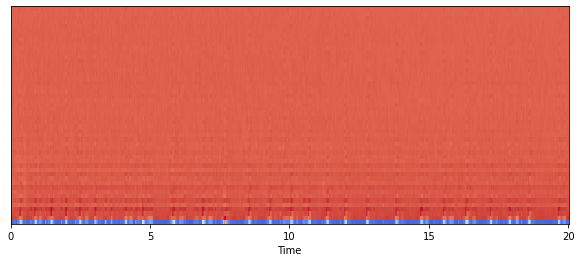

In [0]:
import matplotlib.pyplot as plt
import librosa
plt.figure(figsize=(10, 4))
image = get_mfcc('./data/test0406.wav',isTrain=False, norm=3) # 일단 정규화 안한 상태로 테스트 
print(image)

# image = spec_to_image(image)
librosa.display.specshow(image, x_axis='time')

plt.show()